K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [63]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg` 
'''

df = client.query(sql).to_dataframe()

In [64]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [65]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [66]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [67]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,5.933004,8.641622,1.720307e+02,21.449125,2.773626e+04,4157.673469,1.731156e+02,20.716702,2.000936e+04,3.020809e+03,...,6.871565,1.547108e+03,7.103211,1.305294e+03,1.257525e+00,6.468022e+00,5.046420e+06,5.916969e+06,5.641187e+06,6.685015e+06
1,14219.000000,20552.000000,1.957986e+07,1377.021048,1.120867e+09,78828.811477,1.959438e+07,953.405074,1.120732e+09,5.453152e+04,...,753071.626030,4.311026e+07,753630.041711,4.310507e+07,2.089828e-12,1.380940e-11,2.537501e+03,1.213661e+04,3.669439e+03,1.544081e+04
2,424451.250000,169674.750000,3.620324e+06,600.098395,2.036619e+09,286965.089248,3.603474e+06,2722.819777,2.035262e+09,1.567950e+06,...,347422.644487,1.896901e+08,345814.263658,1.894076e+08,1.344869e-12,-1.798206e-11,1.257230e+04,1.992105e+04,3.365941e+03,9.047254e+03
3,25.286018,31.314449,3.158309e+02,29.925824,9.826970e+04,9379.895977,3.449967e+02,22.413229,9.947098e+04,7.283535e+03,...,21.608868,8.127747e+03,22.953935,8.372320e+03,5.962164e-02,9.067727e+00,8.816365e+05,1.058464e+06,1.132249e+06,1.268830e+06


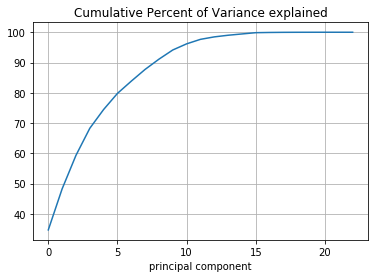

In [68]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [69]:
#elbow method


In [70]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


Text(0.5,1,'Calinski Harabaz Scores')

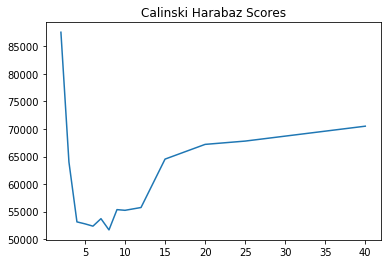

In [71]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

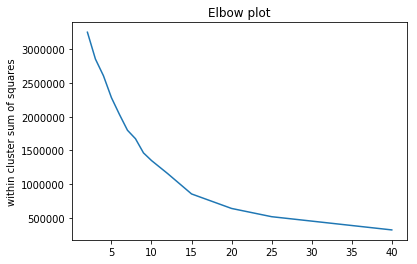

In [72]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [73]:
#optmal number of clusters is around 12
cl = KMeans(20)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [75]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

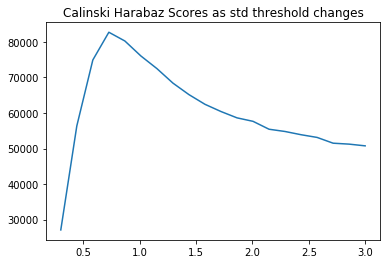

In [76]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [77]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

(-15, 10)

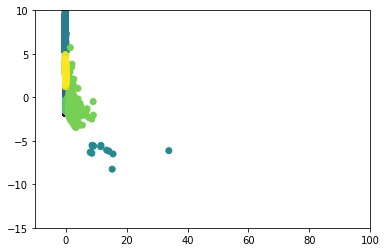

In [78]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

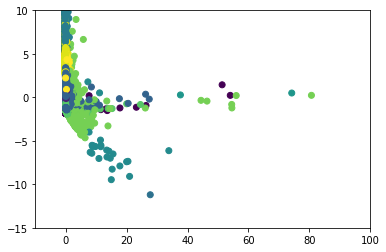

In [79]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [82]:
#recluster after changes
newcl = KMeans(20).fit(newresults)

In [48]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [49]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

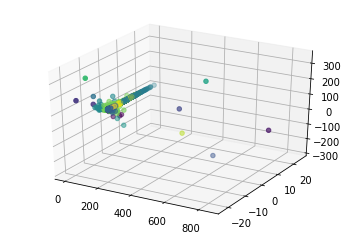

In [80]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

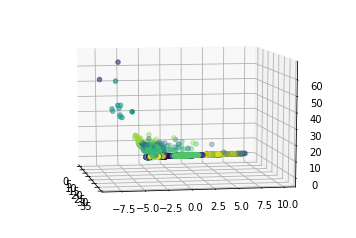

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

for ii in range(10,360,10):
    ax.view_init(elev=10, azim=ii)
    fig.savefig("movie/movie{}.png".format(ii))

In [84]:
c = newcl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,14.681216,22.125030,112.843848,7.866790,4.040353e+04,2.548019e+03,132.815552,7.935447,4.220909e+04,2.242367e+03,...,6.047245,2.226867e+03,7.126188,2.339701e+03,5.772415e-02,1.138987e+00,1.250673e+06,1.790211e+06,1.540178e+06,2.096810e+06
1,4.659947,10.194292,118.413212,29.108836,9.773685e+04,2.438785e+04,119.070497,26.658100,9.836929e+04,2.218682e+04,...,10.404410,8.639971e+03,10.462793,8.696287e+03,-2.220446e-16,1.669775e-13,1.150529e+04,1.479618e+04,1.412886e+04,1.705970e+04
2,6.671949,8.939202,21.609071,3.065647,1.315237e+04,1.937022e+03,23.245899,2.604535,1.396402e+04,1.624196e+03,...,1.808703,1.101483e+03,1.938869,1.170382e+03,1.649618e-02,2.205014e-01,1.997357e+06,2.571615e+06,2.637516e+06,3.028590e+06
3,4.027794,8.371164,18.664567,4.263795,7.976978e+03,1.914655e+03,24.693179,3.236257,9.844243e+03,1.318614e+03,...,1.192194,5.445735e+02,1.558268,6.711621e+02,2.200347e-02,1.038217e+00,2.791305e+06,4.109585e+06,7.218683e+06,8.874164e+06
4,6.000000,4.500000,45752.430914,8670.890304,2.335745e+07,3.893963e+06,45752.435776,11561.188160,2.170815e+07,4.744210e+06,...,3014.830337,1.630184e+06,3014.830675,1.525475e+06,5.943024e-13,3.479883e-12,2.127649e+06,2.506624e+06,3.748636e+06,4.254518e+06
5,11.957941,12.130490,44.043476,5.360660,1.276865e+04,1.556149e+03,47.703868,4.909462,1.388747e+04,1.445525e+03,...,13.406922,3.483750e+03,15.029853,3.893953e+03,3.436381e-02,5.396046e-01,3.028977e+05,2.945574e+05,3.410374e+05,3.159820e+05
6,3.628218,3.773429,19.683846,5.400020,7.439720e+03,2.106566e+03,20.794475,5.410179,7.509974e+03,2.056752e+03,...,1.394746,5.621732e+02,1.464977,5.706132e+02,1.441813e-02,7.312049e-02,9.101787e+06,1.203829e+07,9.471773e+06,1.211694e+07
7,9.313253,124.036145,15710.036168,2124.538092,6.240583e+06,7.301641e+05,18245.156601,933.735735,6.022224e+06,2.271582e+05,...,1163.554006,4.910406e+05,1254.318931,4.869136e+05,1.445783e-01,5.662651e-01,5.085225e+05,9.882288e+05,1.207952e+06,1.776190e+06
8,3.986963,14.805408,25.481749,5.987065,9.671995e+03,2.337084e+03,39.813593,5.081874,1.173356e+04,1.653979e+03,...,1.589875,6.387483e+02,2.412712,8.094337e+02,1.834862e-02,3.814582e-01,9.131272e+05,1.020454e+06,7.415316e+06,9.807568e+06
9,10.572297,15.614211,30.069772,2.728475,1.992876e+04,1.952605e+03,31.257753,2.354351,2.083348e+04,1.671932e+03,...,2.609776,1.722728e+03,2.713418,1.804445e+03,2.009391e-02,3.827510e-01,9.345227e+05,1.113146e+06,1.203467e+06,1.321871e+06


(array([20261., 15609., 15076.,  1054., 16553.,  3293., 18091., 13745.,
         9499., 18156.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

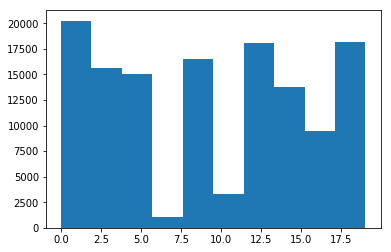

In [85]:
plt.hist(newcl.labels_)